In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score, precision_score
import random
import matplotlib.pyplot as plt

In [4]:
## checando se reconhece a gpu
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
training_percentual = 0.7
matrizes = []
history = []
recall = []
f1score = []
precision = []
images = np.load('images.npy')
labels = np.load('labels.npy')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size = training_percentual)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, train_size = 0.8)

In [33]:
X_train.shape

(3135, 300, 300, 3)

In [34]:
y_test.shape

(1681,)

In [21]:
y_val.shape

(784,)

In [10]:
def buildModel(input_shape=(300, 300, 3), num_classes=1):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=0.001)  # Você pode ajustar a taxa de aprendizado conforme necessário
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [11]:
checkpoint = ModelCheckpoint(
    filepath='D:\\Trabalho-ReconhecimentoPadroes\\models\\best_model.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1)

early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=30, 
    verbose=1)

In [12]:
model = buildModel()

H = model.fit(X_train, y_train, 
                batch_size=8,
                epochs=100,
                validation_data=(X_val, y_val), 
                verbose=1, 
                callbacks=[checkpoint, reduce_lr])

Epoch 1/100
392/392 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8676
Epoch 1: val_loss improved from inf to 10.41280, saving model to D:\Trabalho-ReconhecimentoPadroes\models\best_model.hdf5
392/392 [==============================] - 74s 148ms/step - loss: 0.3435 - accuracy: 0.8676 - val_loss: 10.4128 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 2/100
392/392 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9174
Epoch 2: val_loss improved from 10.41280 to 0.06571, saving model to D:\Trabalho-ReconhecimentoPadroes\models\best_model.hdf5
392/392 [==============================] - 52s 133ms/step - loss: 0.2321 - accuracy: 0.9174 - val_loss: 0.0657 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 3/100
392/392 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9432
Epoch 3: val_loss did not improve from 0.06571
392/392 [==============================] - 50s 128ms/step - loss: 0.1769 - accuracy: 0.9432 - val_loss: 0.1012 - val_ac

In [40]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

# y_test = np.argmax(y_test, axis=0)
print(y_test)

# #draw_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

53/53 [==============================] - 5s 92ms/step
[0 0 0 ... 0 0 0]
[1 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       843
           1       0.00      0.00      0.00       838

    accuracy                           0.50      1681
   macro avg       0.25      0.50      0.33      1681
weighted avg       0.25      0.50      0.33      1681



c:\Users\joao_pedro\.conda\envs\rp_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joao_pedro\.conda\envs\rp_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joao_pedro\.conda\envs\rp_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
matrizes.append(confusion_matrix(y_test, y_pred))
recall.append(recall_score(y_test, y_pred, average=None))
precision.append(precision_score(y_test, y_pred, average=None))
f1score.append(f1_score(y_test, y_pred, average=None))

c:\Users\joao_pedro\.conda\envs\rp_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


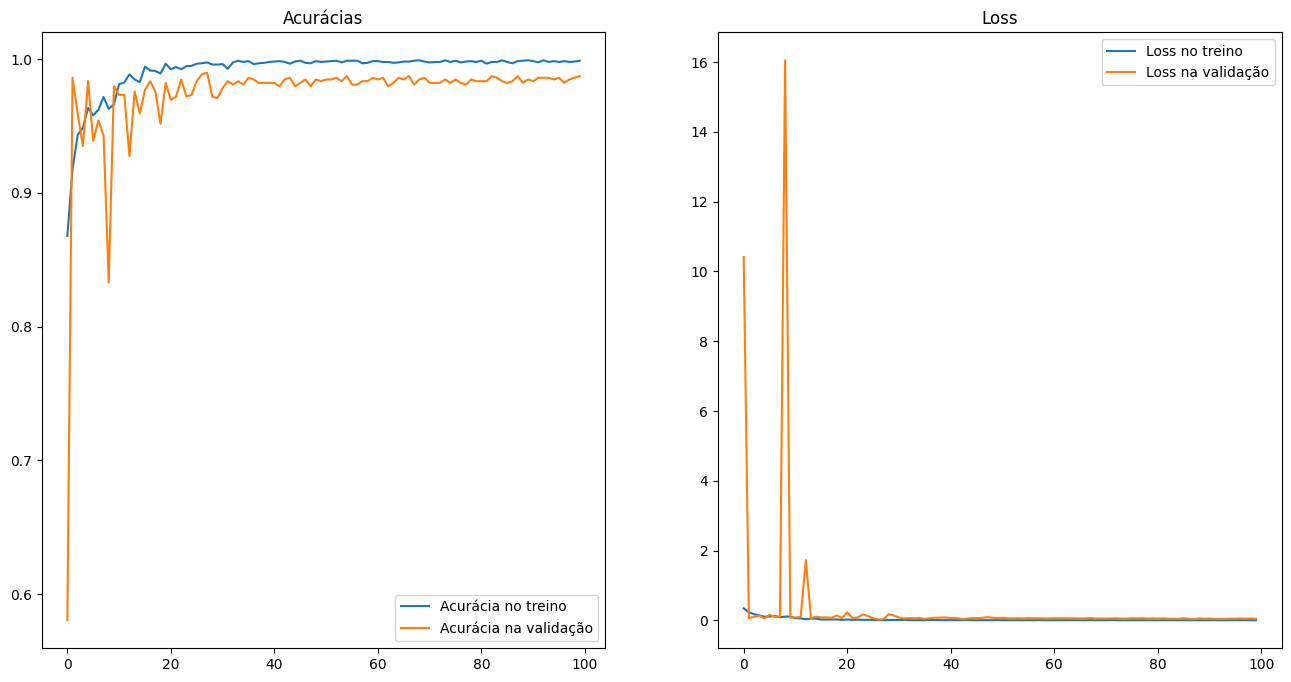

In [39]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(range(100), acc, label='Acurácia no treino')
plt.plot(range(100), val_acc, label='Acurácia na validação')
plt.legend()
plt.title("Acurácias")

plt.subplot(1, 2, 2)
plt.plot(range(100), loss, label='Loss no treino')
plt.plot(range(100), val_loss, label='Loss na validação')
plt.legend()
plt.title("Loss")

plt.show()